# Make Moons

Sklearn's *make_moons* dataset experimentation using Pytorch

In [0]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons

import torch
from torch import nn
import torch.optim as optim


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset visualization

In [2]:
n_samples = 5000

X_train, y_train = make_moons(n_samples=n_samples, noise=0.15, random_state=46)

print(X_train.shape, y_train.shape)

(5000, 2) (5000,)


The make moons dataset contains:

- x: points
- y: label for each point

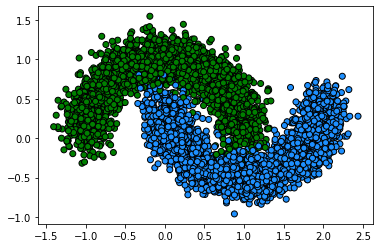

In [3]:
fcolors = ListedColormap(['green', 'dodgerblue'])
x_coords, y_coords = X_train[:, 0], X_train[:, 1]

plt.scatter(x_coords, y_coords, c=y_train, cmap=fcolors, edgecolors='black')

As we can see in the graphic, a Linear Regression model is not enough to recognize the different classes.

We will use a Neural Network to achieve the classification. But we need to define, based on the dataset visualization, what are our dims.

In [0]:
input_dim = 2   # (x,y) coords
hidden_dim = 3  # dense layers dimensions
output_dim = 1  # result dimension

## Neural Network

We have a two dimensional input (x and y coordenates), we'll pass this input trough three dense layers, the first two have dim 3 and activation Relu, the last one dim 1 (our output) and activation sigmoid, as we have a binary classification.

In [5]:
class Model(nn.Module):

  def __init__(self, input_shape, hidden_shape, output_shape):
    super(Model, self).__init__()
    # initialize layers
    self.hidden_1 = nn.Linear(input_shape, hidden_shape)
    self.hidden_2 = nn.Linear(hidden_shape, hidden_shape)
    self.output = nn.Linear(hidden_shape, output_shape)
  
  def forward(self, x):
    # define fordward behavior
    # used when a tensor is passed through the net
    x = torch.relu(self.hidden_1(x))
    x = torch.relu(self.hidden_2(x))
    x = torch.sigmoid(self.output(x))
    return x
  

# init model
model = Model(input_shape=input_dim,
              hidden_shape=hidden_dim,
              output_shape=output_dim).to(device)

model

Model(
  (hidden_1): Linear(in_features=2, out_features=3, bias=True)
  (hidden_2): Linear(in_features=3, out_features=3, bias=True)
  (output): Linear(in_features=3, out_features=1, bias=True)
)

Let's define some helpful functions to use our data.

In [0]:
def batch_to_tensor(X, Y):
  X = torch.tensor(X, dtype=torch.float, requires_grad=False).to(device)
  Y = torch.tensor(np.expand_dims(Y, axis=-1), dtype=torch.float, requires_grad=False).to(device)
  return X, Y

Now, let's define our hyperparameters

In [0]:
# define hyperparameters

epochs = 150
batch_size = 64

# loss & optimizer

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Train the model

In [8]:
# prepare training

train_cycle = itertools.cycle(zip(X_train, y_train))
train_steps = int(n_samples / batch_size)

print(f'Training {epochs} epochs with batch size {batch_size} and {train_steps} steps')

# store losses and accuracy
losses, accuracies = [], []

for e in range(epochs):

  acc = 0.

  # repeat the batch train to cover the num samples
  for _ in range(train_steps):

    # create the train batch
    x_step, y_step = [], []
    for _ in range(batch_size):
      (x, y) = next(train_cycle)
      x_step.append(x); y_step.append(y)
    
    # transform batches into input tensors
    x_step, y_step = batch_to_tensor(x_step, y_step)

    # forward the input through the net
    y_pred = model(x_step)

    # get loss
    loss = criterion(y_pred, y_step)
    
    # optimize model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # get accuracy
    model.eval()        
    with torch.no_grad():
      outputs = np.array(list(y_pred.detach().cpu().numpy().round()))
      step_acc = (outputs == y_step.detach().cpu().numpy()).sum()
    model.train()
    acc += step_acc / batch_size
  
  losses.append(loss.item())
  accuracies.append(acc)

print(f'Final loss: {losses[-1]} - Final accuracy: {accuracies[-1]}')

Training 150 epochs with batch size 64 and 78 steps
Final loss: 0.3807414174079895 - Final accuracy: 66.71875


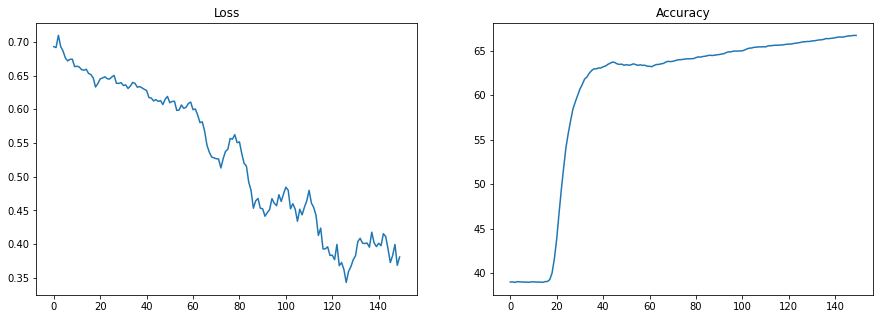

In [14]:
# show training history

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(losses)

ax[1].set_title('Accuracy')
ax[1].plot(accuracies)

plt.show()

They are a little creepy, but I think it's OK. It's probably due to the batch size / step size stuff.